In [ ]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.5 MB/s eta 0:00:00


In [ ]:
!pip install gymnasium[atari]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.2 MB/s eta 0:00:00


In [ ]:
!pip install gymnasium[accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 5.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446659 sha256=5526797dc6e7b405c2a02715348cc4b92ff13966ddc3ccd2b17990a9523cdf93
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


In [ ]:
import gymnasium
import torch
import numpy as np
from torch.autograd import Variable

In [ ]:
!pip install --upgrade gym ale-py

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 7.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827618 sha256=c95f76fe27ed5149daccf69c3aee2a79e03b728e07cde1451d0a323260242301
  Stored in directory: /root/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.6 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


In [ ]:
env = gymnasium.make("ALE/Tetris-ram-v5")

In [ ]:
env.observation_space.shape[0]

128

In [ ]:
def gen_epsilon_greedy_policy(estimator, epsilon, n_action):
    def policy_function(state):
            probs = torch.ones(n_action) * epsilon / n_action
            q_values = estimator.predict(state)
            best_action = torch.argmax(q_values).item()
            probs[best_action] += 1.0 - epsilon
            action = torch.multinomial(probs, 1).item()
            return action
    return policy_function

In [ ]:
class LR_Estimate():
    def __init__(self, n_feat, n_state, n_action, lr=0.05):#n_state - размерность состояний теперь
        self.w, self.b = self.get_gaussian_wb(n_feat,n_state)
        self.n_feat = n_feat
        self.models = []
        self.optimizers = []
        self.criterion = torch.nn.MSELoss()
        for _ in range(n_action):
            model = torch.nn.Linear(n_feat,1)
            self.models.append(model)
            optimizer = torch.optim.SGD(model.parameters(), lr)
            self.optimizers.append(optimizer)

    def get_gaussian_wb(self, n_feat, n_state, sigma=.2):
        torch.manual_seed(0)
        w = torch.randn((n_state,n_feat))/sigma
        b = torch.rand((n_feat))* 2.0 * np.pi
        return w, b

    def get_feature(self, s):
        features = (2.0 / self.n_feat) ** 0.5 * torch.cos(torch.matmul(torch.Tensor(s).float(), self.w) + self.b)

        return features

    def update(self, s, a, y):
        features = Variable(self.get_feature(s))
        y_pred = self.models[a](features)

        loss = self.criterion(y_pred, Variable(torch.Tensor([y])))

        self.optimizers[a].zero_grad()
        loss.backward()
        self.optimizers[a].step()

    def predict(self,s):
        features = self.get_feature(s)
        # print(features)
        with torch.no_grad():
            m = [model(features) for model in self.models]
            b = torch.Tensor(len(m), len(m[0]))

            torch.cat(m, out=b)
            return b

In [ ]:
estimator = LR_Estimate(10, env.observation_space.shape[0], env.action_space.n)
policy = gen_epsilon_greedy_policy(estimator, 0.1, env.action_space.n)

In [ ]:
rewards = np.zeros(30)
for traj_num in range(30):
    state = env.reset()[0]
    is_done = False
    while not is_done:
      action = policy(state)
      new_state, reward, is_done, __,  info = env.step(action)
      state = new_state
      rewards[traj_num] += reward
      rewards[traj_num] += 0.01

<ipython-input-22-e22f447b083a>:42: UserWarning: An output with one or more elements was resized since it had shape [5, 1], which does not match the required output shape [5]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  torch.cat(m, out=b)


In [ ]:
rewards

array([5.05, 3.97, 4.88, 3.89, 4.61, 4.01, 3.85, 3.79, 3.73, 4.13, 4.13,
       4.33, 5.05, 3.85, 3.85, 3.53, 3.89, 6.17, 3.89, 4.73, 4.33, 4.41,
       4.01, 3.89, 4.13, 3.87, 3.93, 5.77, 4.01, 4.49])

In [ ]:
mean_reward = sum(rewards) / len(rewards)

In [ ]:
mean_reward

4.272333333333287

In [ ]:
from scipy import stats

In [ ]:
interval = stats.norm.interval(0.95, loc=mean_reward, scale=stats.tstd(rewards, axis=0))
print(interval)

(3.0843223594152898, 5.460344307251284)


In [ ]:
def q_learning(env, estimator, n_episode, epsilon, n_action, gamma=1.0, epsilon_decay=0.99):
    for episode in range(n_episode):
        policy = gen_epsilon_greedy_policy(estimator, epsilon * epsilon_decay ** episode, n_action)
        state = env.reset()[0]
        is_done = False
        while not is_done:
            action = policy(state)
            new_state, reward, is_done, __,  info = env.step(action)
            q_values_next = estimator.predict(new_state)
            if reward == 0:
              reward = 0.01
            else:
              reward = 100
            td_target = reward + gamma * torch.max(q_values_next)
            estimator.update(state, action, td_target)
            total_reward_episode[episode] += reward
        state = new_state

In [ ]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_feature = 100
lr = 0.03
estimator = LR_Estimate(n_feature, n_state, n_action, lr)

n_episode = 500
total_reward_episode = [0] * n_episode
q_learning(env, estimator, n_episode, 0.1, n_action)

<ipython-input-22-e22f447b083a>:42: UserWarning: An output with one or more elements was resized since it had shape [5, 1], which does not match the required output shape [5]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  torch.cat(m, out=b)


In [ ]:
import matplotlib.pyplot as plt

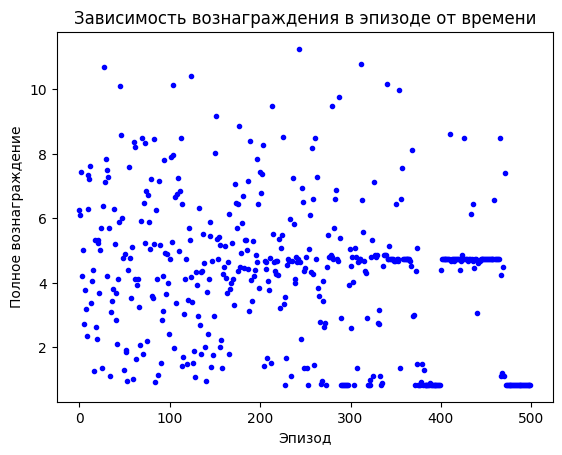

In [ ]:
plt.plot(total_reward_episode, 'b.')
plt.title('Зависимость вознаграждения в эпизоде от времени')
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.show()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class ActorCriticModel(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super(ActorCriticModel, self).__init__()
        self.fc = nn.Linear(n_input, n_hidden)
        self.action = nn.Linear(n_hidden, n_output)
        self.value = nn.Linear(n_hidden, 1)

    def forward(self, x):
        x = torch.Tensor(x)
        x = F.mish(self.fc(x))
        action_probs = F.softmax(self.action(x), dim=-1)
        state_value = self.value(x)
        return action_probs, state_value

In [ ]:
class PolicyNetwork():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.001):
        self.model = ActorCriticModel(n_state, n_action, n_hidden)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.9)

    def predict(self, s):
        return self.model(torch.tensor(s))

    def update(self, returns, log_probs, state_values):
        loss = 0
        for log_prob, value, Gt in zip(log_probs, state_values, returns):
            advantage = Gt - value.item()
            policy_loss = -log_prob * advantage
            value_loss = F.smooth_l1_loss(value, Gt)
            loss += policy_loss + value_loss

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_action(self, s):
        ac_probs, state_value = self.predict(s)
        action = torch.multinomial(ac_probs, 1).item()
        log_prob = torch.log(ac_probs[action])
        return action, log_prob, state_value

In [ ]:
def actor_critic(env, estimator, n_episode, gamma=1.0):
    for episode in range(n_episode):
        log_probs = []
        rewards = []
        state_values = []

        state = env.reset()[0]
        while True:
            action, log_prob, state_value = estimator.get_action(state.astype(np.float32))
            next_state, reward, is_done, truncated,  info = env.step(action)
            reward += 0.01
            total_reward_episode[episode] += reward

            log_probs.append(log_prob)
            rewards.append(reward)
            state_values.append(state_value)

            if is_done or truncated:
                returns = []
                Gt = 0
                pw = 0
                for reward in rewards[::-1]:
                    Gt += gamma ** pw * reward
                    pw += 1
                    returns.append(Gt)

                returns = returns[::-1]
                returns = torch.Tensor(returns)

                returns = (returns - torch.mean(returns)) / (torch.std(returns) + 1e-9)

                estimator.update(returns, log_probs, state_values)

                if total_reward_episode[episode] >= 195:
                    estimator.schedufler.step()

                print(f'Episode: {episode}, total reward: {total_reward_episode[episode]}')
                break

            state = next_state

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 256
lr = 0.03
policy_net = PolicyNetwork(n_state, n_action, n_hidden, lr)

n_episode = 800
gamma = 0.9
total_reward_episode = [0] * n_episode

In [ ]:
actor_critic(env, policy_net, n_episode, gamma)

<ipython-input-14-764a8b304f84>:15: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value, Gt)


Episode: 0, total reward: 7.209999999999891
Episode: 1, total reward: 11.96999999999979
Episode: 2, total reward: 5.929999999999918
Episode: 3, total reward: 10.769999999999815
Episode: 4, total reward: 10.52999999999982
Episode: 5, total reward: 9.60999999999984
Episode: 6, total reward: 10.289999999999825
Episode: 7, total reward: 8.60999999999986
Episode: 8, total reward: 12.169999999999785
Episode: 9, total reward: 7.489999999999885
Episode: 10, total reward: 10.169999999999828
Episode: 11, total reward: 11.769999999999794
Episode: 12, total reward: 10.209999999999827
Episode: 13, total reward: 6.009999999999916
Episode: 14, total reward: 10.729999999999816
Episode: 15, total reward: 8.059999999999873
Episode: 16, total reward: 9.969999999999832
Episode: 17, total reward: 8.16999999999987
Episode: 18, total reward: 8.809999999999857
Episode: 19, total reward: 8.129999999999871
Episode: 20, total reward: 10.52999999999982
Episode: 21, total reward: 10.729999999999816
Episode: 22, to

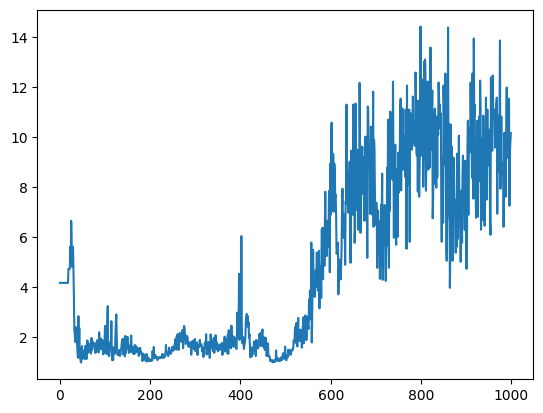

In [ ]:
plt.plot(total_reward_episode)

In [ ]:
mean_reward = sum(total_reward_episode) / len(total_reward_episode)

In [ ]:
mean_reward

4.719979999999934

In [ ]:
interval = stats.norm.interval(0.95, loc=mean_reward, scale=stats.tstd(total_reward_episode, axis=0))
print(interval)

(-2.4168612577658255, 11.856821257765693)
